Rows: 9551 | Columns: 21
Rows after cleaning: 9542
TF‑IDF matrix shape: (9542, 145)


C:\Users\LENOVO\Downloads\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


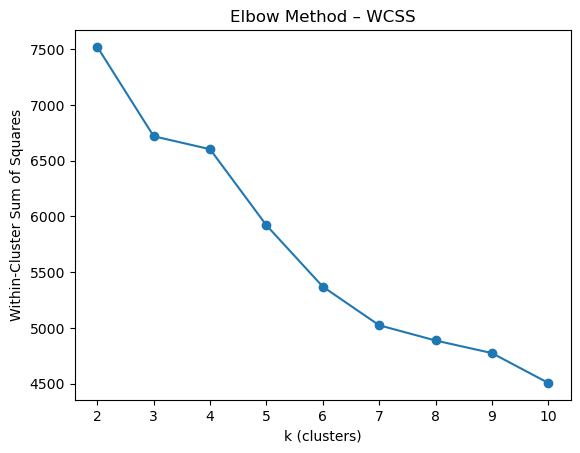

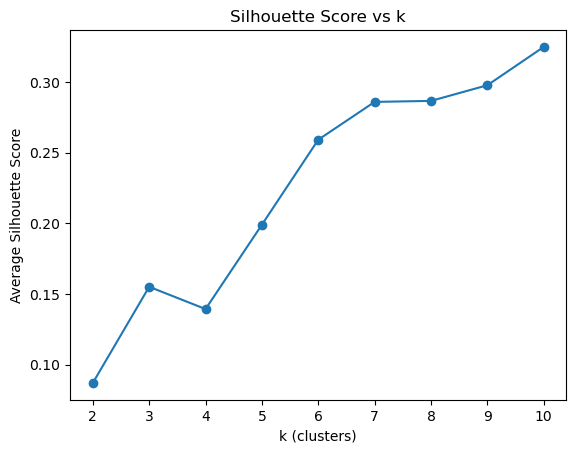

Enter k to use (e.g., 5):  5



🌟 Cluster 0 – top cuisines:
street food, mithai, south indian, north indian, fast food, chinese, desserts, beverages, bakery, indian

🌟 Cluster 1 – top cuisines:
north indian, world cuisine, drinks only, finger food, filipino, fast food, european, dí_ner, durban, diner

🌟 Cluster 2 – top cuisines:
fast food, bakery, pizza, chinese, burger, north indian, raw meats, desserts, beverages, italian

🌟 Cluster 3 – top cuisines:
mughlai, cafe, bakery, north indian, desserts, italian, continental, south indian, ice cream, american

🌟 Cluster 4 – top cuisines:
chinese, north indian, mughlai, south indian, continental, fast food, thai, italian, cafe, mithai

===== Cluster 0 – sample restaurants =====
            SpiceKlub
         Swati Snacks
          Bikanerwala
Brijwasi Chat Bhandar
      The Kulcha Land

===== Cluster 1 – sample restaurants =====
    Time2Eat - Mama Chicken
                     Eat On
           Charming Chicken
Bubby Fish & Chicken Corner
             Brothers Dhaba

=====

In [2]:
# Zomato Cuisine Clustering for Recommendations
# =========================================================
# Author: Subhash Gowtham Veer T
# Dataset file expected: 'zomato.csv' (ISO‑8859‑1 encoding)

# 1️⃣  Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 2️⃣  Load & inspect
df = pd.read_csv("zomato.csv.zip", encoding="ISO-8859-1")
print("Rows:", len(df), "| Columns:", df.shape[1])
df.head()

# 3️⃣  Minimal column subset & cleaning
keep_cols = ["Restaurant Name", "Cuisines", "Aggregate rating", "Votes"]
df = df[keep_cols].copy()

# Drop rows with missing cuisines
df.dropna(subset=["Cuisines"], inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional quality filter – uncomment if you want only decent‑rated places
# df = df[df["Aggregate rating"] >= 3.5]

print("Rows after cleaning:", len(df))

# 4️⃣  TF‑IDF vectorisation on 'Cuisines'
# Use comma / slash as delimiters so each cuisine word is a token
def cuisine_tokeniser(text):
    return [t.strip() for part in text.split(",") for t in part.split("/") if t.strip()]

vectoriser = TfidfVectorizer(tokenizer=cuisine_tokeniser)
X = vectoriser.fit_transform(df["Cuisines"])
print("TF‑IDF matrix shape:", X.shape)

# 5️⃣  Choose optimal k (Elbow + Silhouette)
wcss = []
sil_scores = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X)
    wcss.append(km.inertia_)
    sil = silhouette_score(X, km.labels_)
    sil_scores.append(sil)

# ------  Elbow & silhouette visual check  ------
plt.figure()
plt.plot(K_RANGE, wcss, marker="o")
plt.title("Elbow Method – WCSS")
plt.xlabel("k (clusters)")
plt.ylabel("Within‑Cluster Sum of Squares")
plt.show()

plt.figure()
plt.plot(K_RANGE, sil_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k (clusters)")
plt.ylabel("Average Silhouette Score")
plt.show()

# Pick k with high silhouette & elbow bend
optimal_k = int(input("Enter k to use (e.g., 5): ") or 5)

# 6️⃣  Final K‑Means fit
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df["Cluster"] = kmeans.fit_predict(X)

# 7️⃣  Quick insight: top cuisines per cluster
def top_terms_per_cluster(km_model, vocab, n_terms=10):
    centres = km_model.cluster_centers_
    terms = np.array(vocab)
    for idx, centroid in enumerate(centres):
        top_ids = centroid.argsort()[-n_terms:][::-1]
        print(f"\n🌟 Cluster {idx} – top cuisines:")
        print(", ".join(terms[top_ids]))

top_terms_per_cluster(kmeans, vectoriser.get_feature_names_out())

# 8️⃣  Sample restaurants per cluster
for c in range(optimal_k):
    print(f"\n===== Cluster {c} – sample restaurants =====")
    print(df[df["Cluster"] == c]["Restaurant Name"].head(5).to_string(index=False))

# 9️⃣  Save clustered output (optional)
df.to_csv("zomato_clustered.csv", index=False)
print("\nClustered data saved to 'zomato_clustered.csv' ✅")
